<a href="https://colab.research.google.com/github/farhanabrar/MLClass/blob/main/TUGAS/WEEK2/Tugasregulized_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:
test = pd.read_csv('/content/test.csv')
train = pd.read_csv('/content/train.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66a4a8b590>,
      dtype=object)

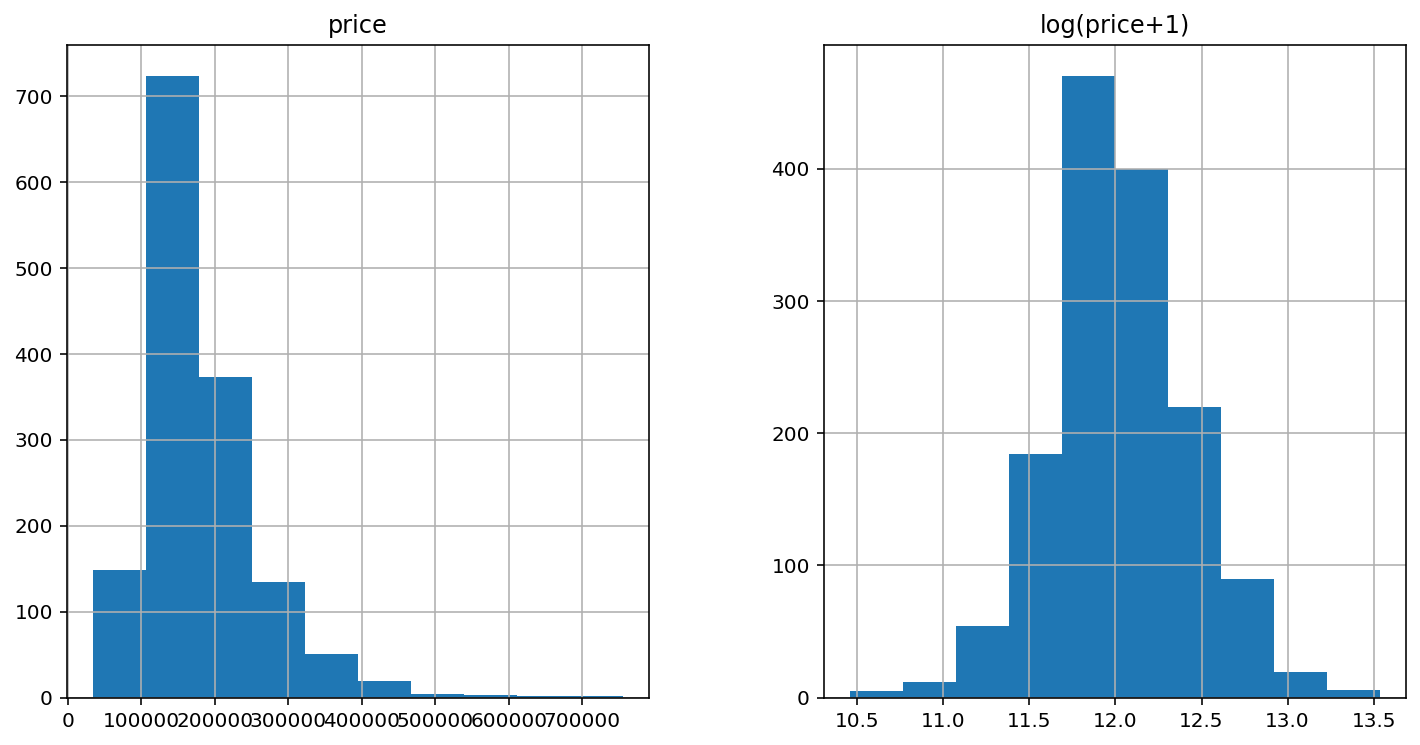

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0,6.0)
prices = pd.DataFrame({"price": train["SalePrice"], "log(price+1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness (kemencengan)
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [9]:
#creating metrics for sklear 
x_train = all_data[:train.shape[0]]
x_test = all_data[train.shape[0]:]
y = train.SalePrice

In [13]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
  rmse= np.sqrt(-cross_val_score(model, x_train, y, scoring="neg_mean_squared_error", cv = 5))
  return(rmse)

In [14]:
model_ridge = Ridge()

In [15]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

Text(0, 0.5, 'rmse')

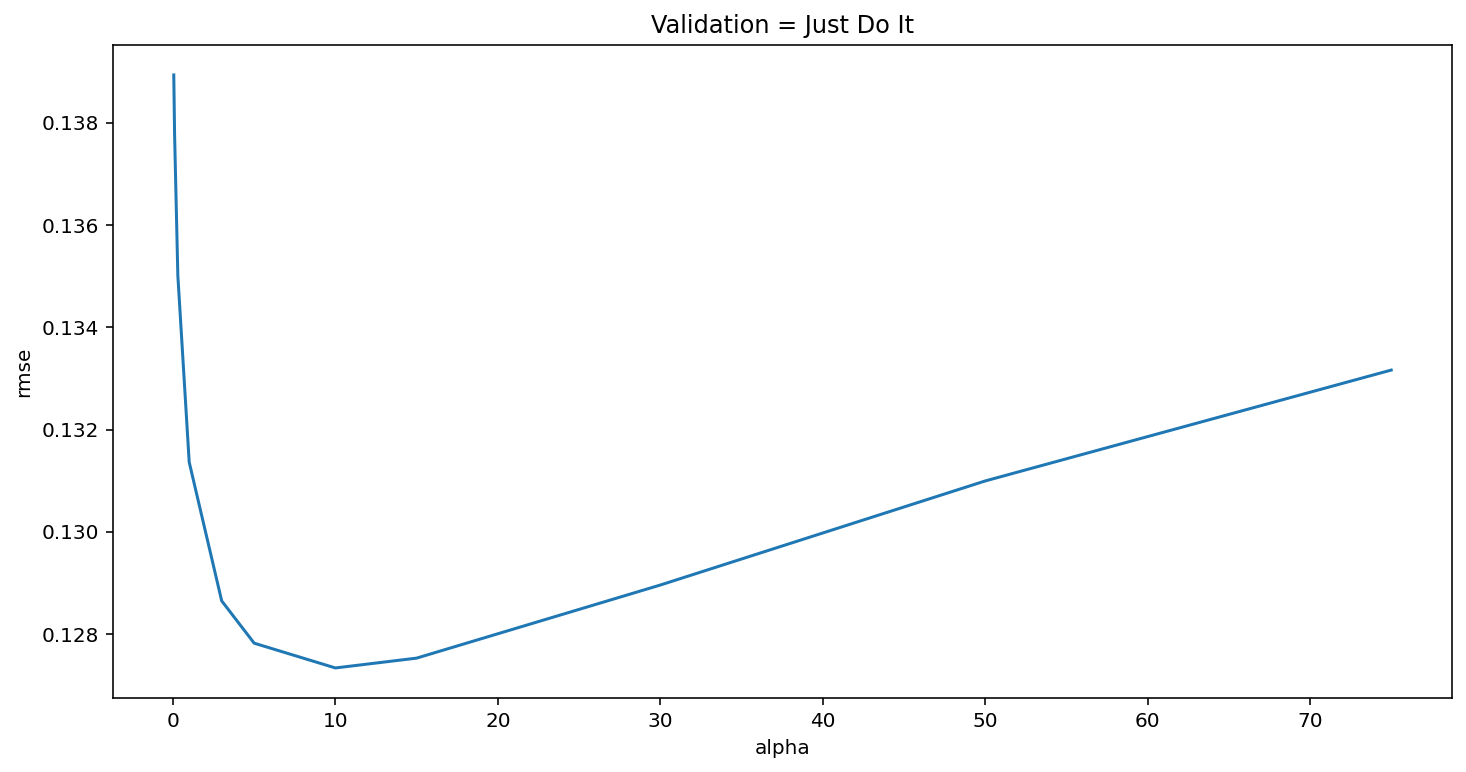

In [16]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title= "Validation = Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [17]:
cv_ridge.min()

0.12733734668670757

In [18]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(x_train, y)

In [19]:
rmse_cv(model_lasso).mean()

0.12256735885048142

In [20]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)

In [23]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)) + " vaiables")

Lasso picked 110 variables and eliminated the other 178 vaiables


In [24]:
imp_coef = pd.concat([coef.sort_values().head(10), 
                      coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

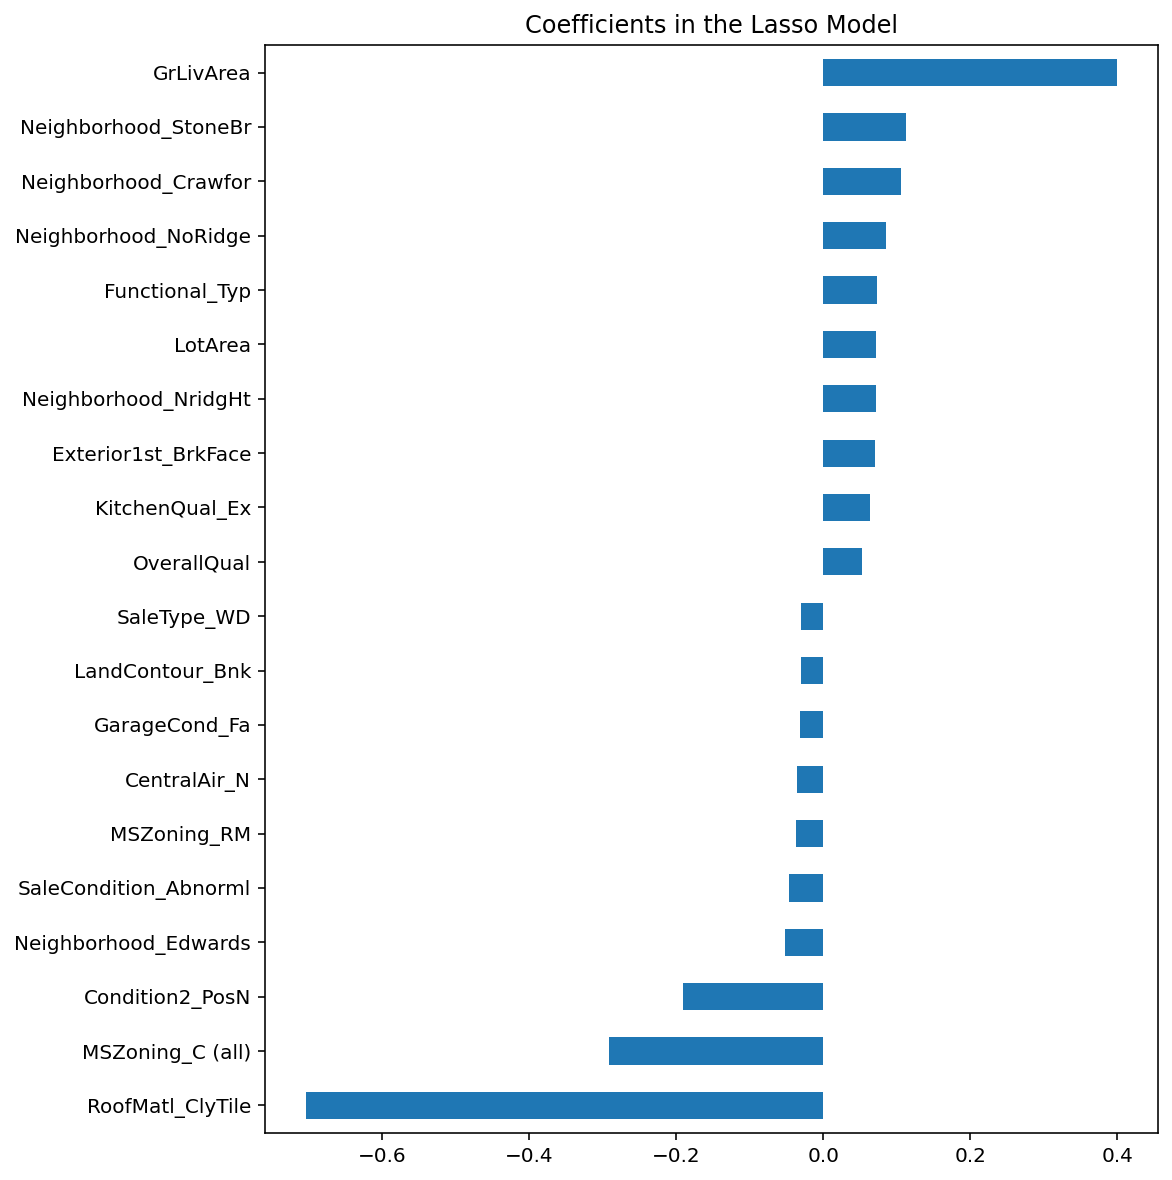

In [25]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title('Coefficients in the Lasso Model')

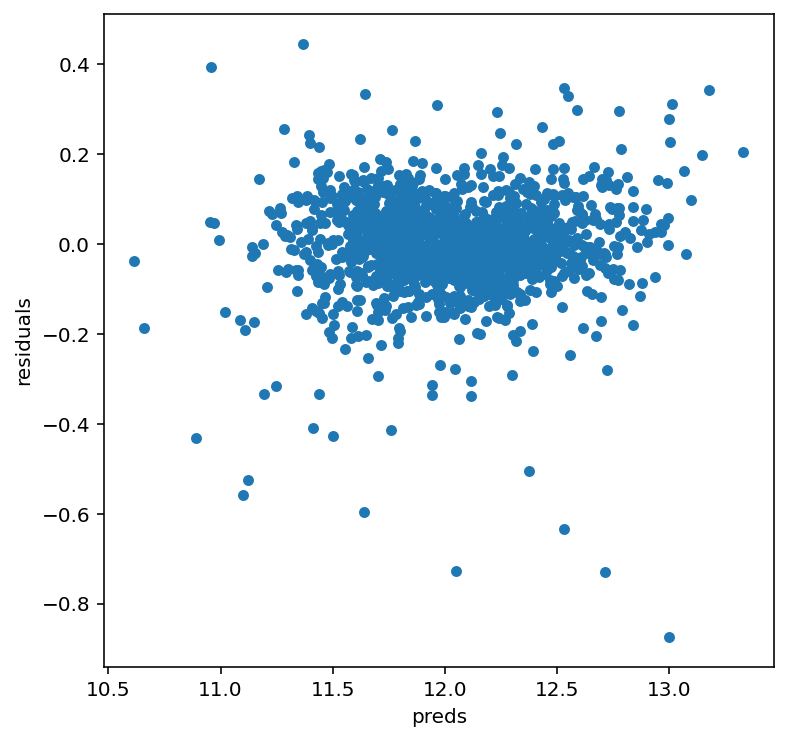

In [28]:
#residual
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(x_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter")

In [29]:
import xgboost as xgb

In [30]:
dtrain = xgb.DMatrix(x_train, label = y)
dtest = xgb.DMatrix(x_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

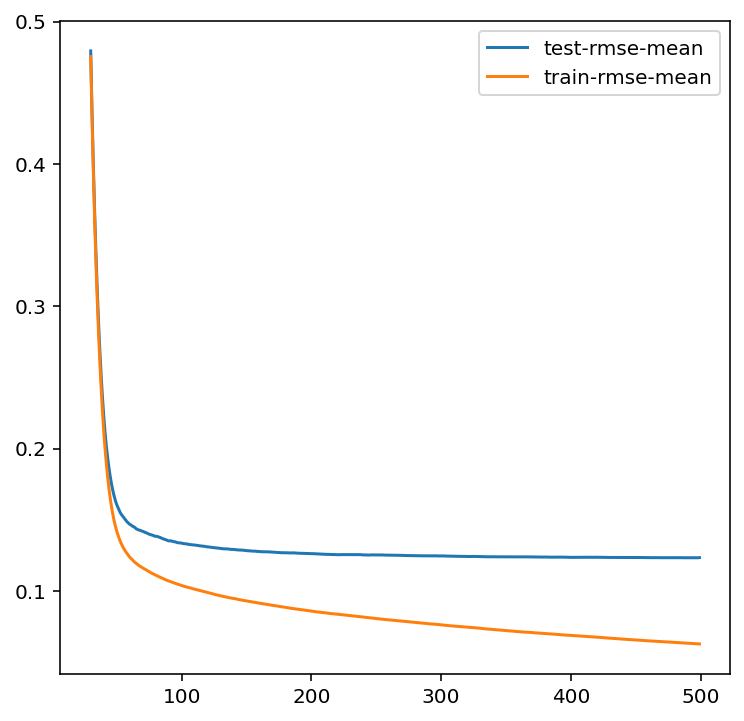

In [31]:
model.loc[30:, ["test-rmse-mean", "train-rmse-mean"]].plot()

In [32]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth = 2, learning_rate = 0.1)
model_xgb.fit(x_train, y)

[14:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=2, n_estimators=360)

In [33]:
xgb_preds = np.expm1(model_xgb.predict(x_test))
lasso_preds = np.expm1(model_lasso.predict(x_test))

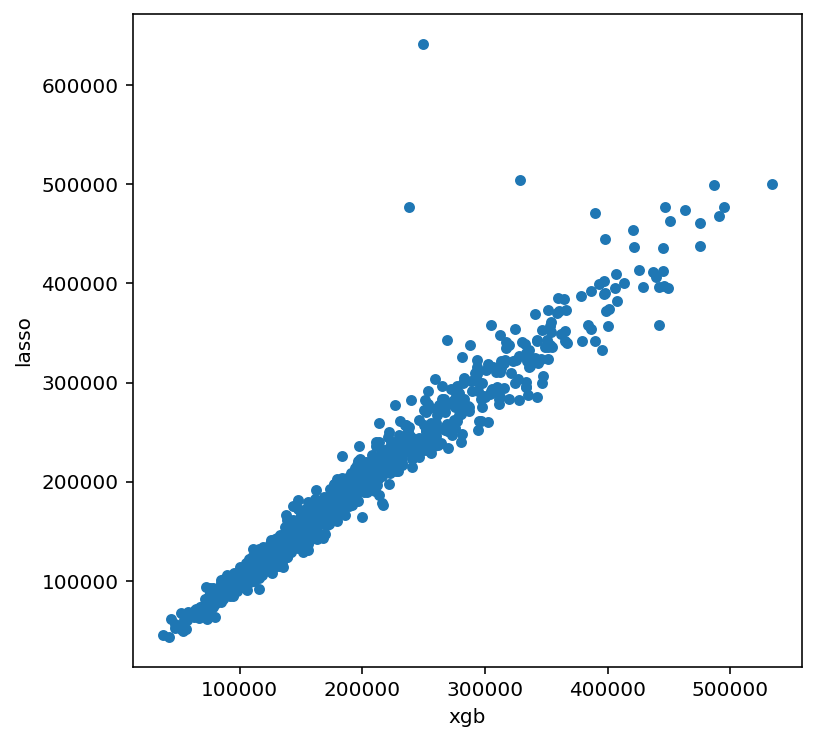

In [34]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [35]:
preds = 0.7*lasso_preds + 0.3*xgb_preds 

In [36]:
solution =pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)

In [37]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [38]:
x_train = StandardScaler().fit_transform(x_train)

In [39]:
X_tr, X_val, y_tr, y_val = train_test_split(x_train, y, random_state = 3)

In [40]:
X_tr.shape

(1095, 288)

In [41]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [50]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = x_train.shape[1]))
model.add(Dense(1, input_dim = x_train.shape[1], kernel_regularizer=l1(0.001)))
model.compile(loss = "mse", optimizer = "adam")

In [51]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 289       
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [53]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

35/35 [==============================] - 1s 11ms/step - loss: 147.0226 - val_loss: 146.7805


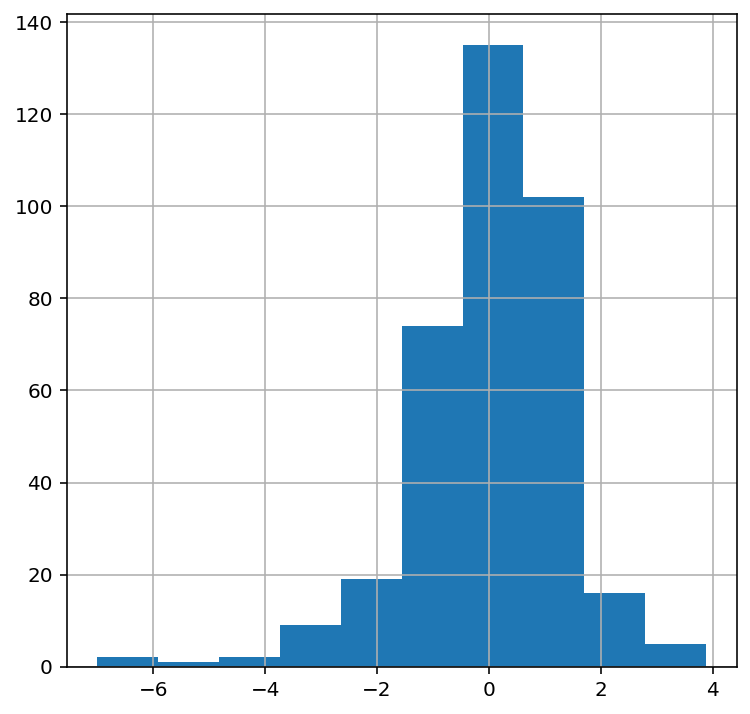

In [54]:
pd.Series(model.predict(X_val)[:,0]).hist()